# Forecasting Products Sales - Time Series Analysis
In this notebook I will perform a time series analysis on products sales.
<br/><br/>**The Data**
<br/>The data is taken from kaggle open datasets collection
* **train.csv** - contains sales data for 50 products at 50 different stores (daily sales) - **2013 - 2017**
* **test.csv** - contain a test data to validate the prediction performance

Our goal is to predict future sales for each item at each store

<br/>Brefore we dive in, let's talk a little bit about time series in general...
## What Exactly is a Time Series?
As the name suggests, TS is a collection of data points collected at constant time intervals. These are analyzed to determine the long term trend so as to forecast the future or perform some other form of analysis. But what makes a TS different from say a regular regression problem? There are 2 things:

* It is time dependent. So the basic assumption of a linear regression model that the observations are independent doesn’t hold in this case.
* Along with an increasing or decreasing trend, most TS have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, if you see the sales of a woolen jacket over time, you will invariably find higher sales in winter seasons.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
%matplotlib inline

# Loading the Data

In [2]:
train_df = pd.read_csv("data/train.csv", parse_dates=['date'], index_col=['date'])
train_df.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


# <br/>Let's look at the target variable (sales) that we need to predict
We're going to plot all the sales grouped by the store, meaning, each store will have a separate color in the graph

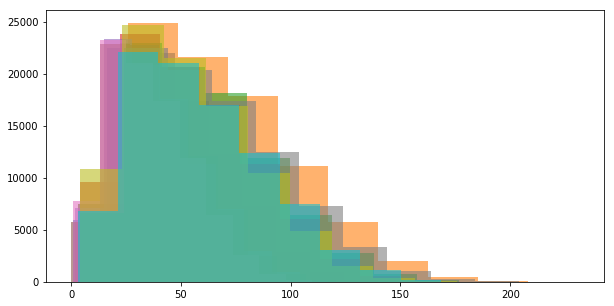

In [3]:
train_df.groupby('store')['sales'].hist(grid=False, figsize=(10,5), alpha=0.6)
None

The above plot shows that all the stores have almost the same sales distrbution

# <br/>Preparing The Data For Analysis
Let's try to see what data is available to us for forecasting
<br/>We want to answer the following questions:
* How many stores do we have?
* How many items is being sold at each store?

In [4]:
print('how many items are being sold on each store?')
train_df.groupby('store').item.nunique()

how many items are being sold on each store?


store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

So we see that we have 10 stores and on each one, 50 items are being sold
<br/>**Now Let's check the sales across time in each store**, and see if we find patterns

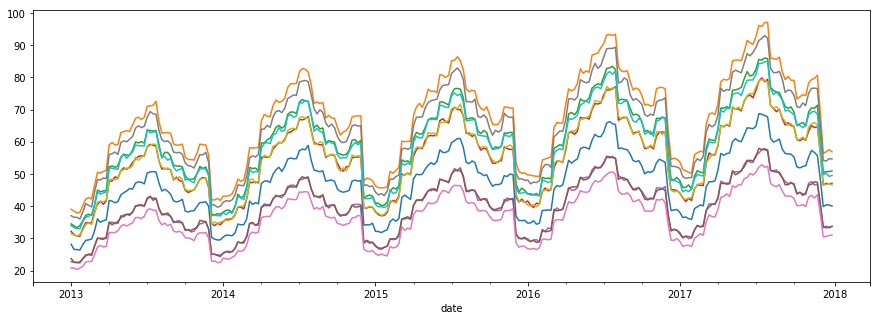

In [5]:
stores = set(train_df.store.values)
train_df['sales'] = train_df['sales'] * 1.0
for i in stores:
    store_df = train_df[train_df.store == i].sort_index(ascending = True)
    store_df.sales.resample('W').mean().plot(figsize=(15,5))

We can clearly see that each year begins with low sales and arround mid year we have a pick in sales. We also see that all stores acts the same (weird)

<br/>In order to do our analysis and predictions, we're going to average all the **month-start (MS)** values and focus on them
<br/>To be more specific, we want to predict the average month start value across all stores and all products

In [6]:
ts = train_df.resample('W').sales.mean()
ts['2017'].head()

date
2017-01-01    41.897143
2017-01-08    40.032000
2017-01-15    39.971714
2017-01-22    39.975429
2017-01-29    39.812857
Freq: W-SUN, Name: sales, dtype: float64

<br/>Now let's start the analysis by plotting the time series data of the data we selected to work with

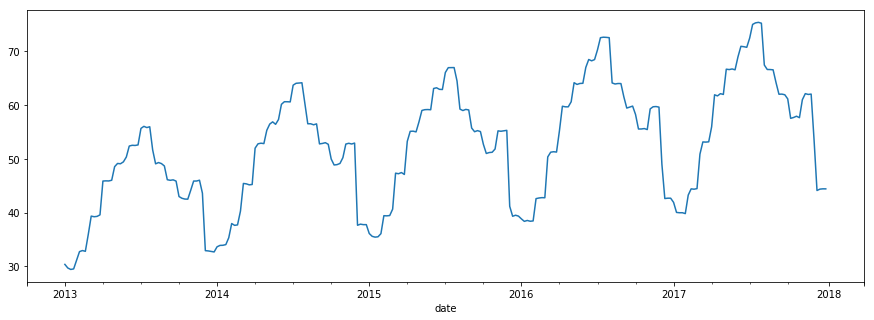

In [7]:
ts.plot(figsize=(15,5))
None

# <br/>Check Stationarity of the Time Series
A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future.
<br/><br/>Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:
* **constant mean**
* **constant variance**
* **autocovariance that does not depend on time.**

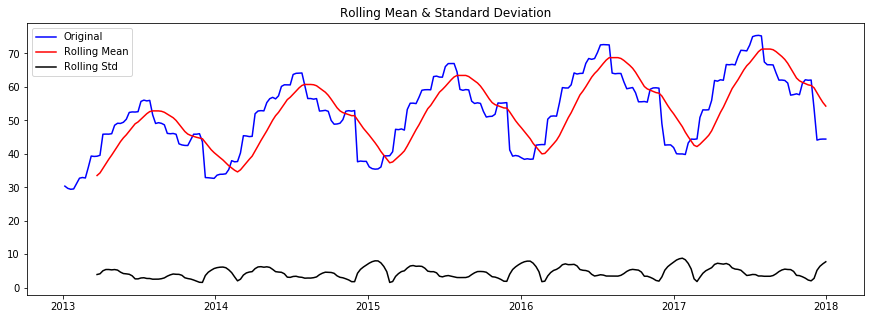

Results of Dickey-Fuller Test:
Test Statistic                  -3.366657
p-value                          0.012149
#Lags Used                       4.000000
Number of Observations Used    256.000000
Critical Value (1%)             -3.456155
Critical Value (5%)             -2.872897
Critical Value (10%)            -2.572822
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, period=12):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(period).mean()
    rolstd = timeseries.rolling(period).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ts)

<br/>Lets understand what is making a TS non-stationary. There are 2 major reasons behind non-stationaruty of a TS:
1. **Trend** – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. **Seasonality** – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using the following:
<br/>
* **Plotting Rolling Statistics:** We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.
* **Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

# ACF and PACF

/home/ds/python-envs/env3.6/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


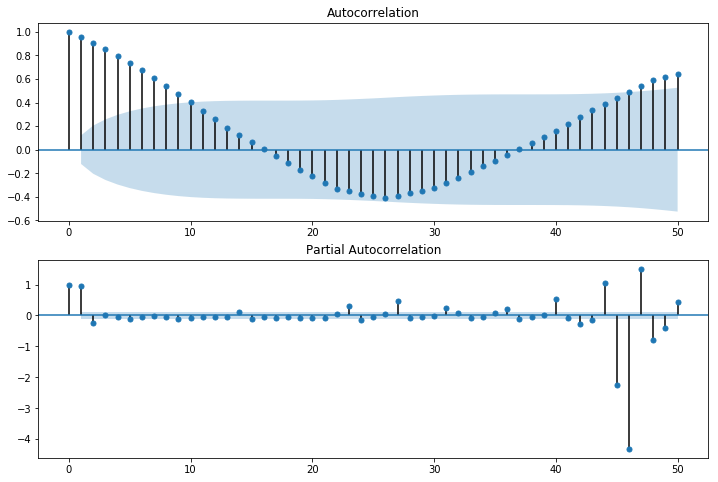

In [9]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags=50, ax=ax2)

# <br/>Forecasting a Time Series
Let's give a brief introduction to ARIMA. I won’t go into the technical details but you should understand these concepts in detail if you wish to apply them more effectively. ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. 
<br/>The predictors depend on the parameters (p,d,q) of the ARIMA model:

* **Number of AR (Auto-Regressive) terms (p)**: AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
* **Number of Differences (d)**: These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.
* **Number of MA (Moving Average) terms (q)**: MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

## SARIMA Model
The seasonal part of an ARIMA model has the same structure as the non-seasonal part: it may have an AR factor, an MA factor, and/or an order of differencing.
<br/>In the seasonal part of the model, all of these factors operate across multiples of lag s (the number of periods in a season).
* A seasonal ARIMA model is classified as an ARIMA(p,d,q)x(P,D,Q) model, where P=number of seasonal autoregressive (SAR) terms, D=number of seasonal differences, Q=number of seasonal moving average (SMA) terms
* In identifying a seasonal model, the first step is to determine whether or not a seasonal difference is needed, in addition to or perhaps instead of a non-seasonal difference. You should look at time series plots and ACF and PACF plots for all possible combinations of 0 or 1 non-seasonal difference and 0 or 1 seasonal difference. Caution: don't EVER use more than ONE seasonal difference, nor more than TWO total differences (seasonal and non-seasonal combined).
* If the seasonal pattern is both strong and stable over time (e.g., high in the Summer and low in the Winter, or vice versa), then you probably should use a seasonal difference regardless of whether you use a non-seasonal difference, since this will prevent the seasonal pattern from "dying out" in the long-term forecasts

MSE: 15.671461790774668
RMSE: 3.9587197161171535
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9755      0.019     52.088      0.000       0.939       1.012
ma.L1         -0.7257      0.091     -7.965      0.000      -0.904      -0.547
ma.L2          0.2242      0.095      2.359      0.018       0.038       0.411
ar.S.L52       0.7706      0.065     11.835      0.000       0.643       0.898
ar.S.L104      0.0662      0.074      0.897      0.370      -0.078       0.211
ma.S.L52      -1.0003    792.225     -0.001      0.999   -1553.733    1551.733
sigma2         0.2466    195.401      0.001      0.999    -382.731     383.225


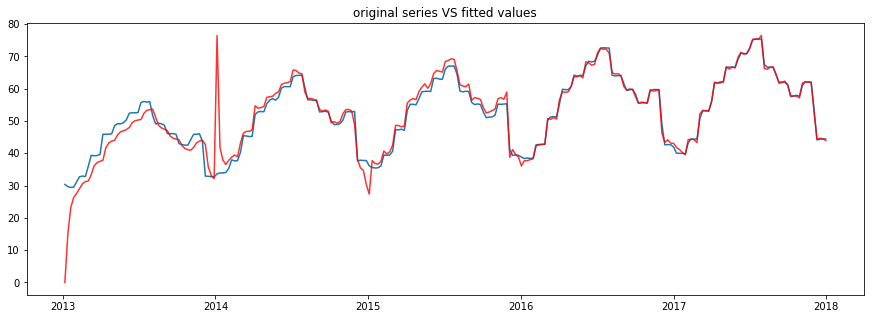

In [10]:
from sklearn.metrics import mean_squared_error

model = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 0, 2),
                                seasonal_order=(2, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_ARIMA = model.fit(disp=0, maxiter=200)
plt.figure(figsize=(15,5))
plt.plot(ts)
plt.title('original series VS fitted values')
plt.plot(results_ARIMA.fittedvalues, color='red', alpha=0.8)

mse = mean_squared_error(ts, results_ARIMA.fittedvalues)
rmse = np.sqrt(sum((results_ARIMA.fittedvalues-ts)**2)/len(ts))

print('MSE: %s' % mse)
print('RMSE: %s' % rmse)

print(results_ARIMA.summary().tables[1])

## ACF and PACF plots of the residuals
* **ACF** describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information - This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.
* **PACF** only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

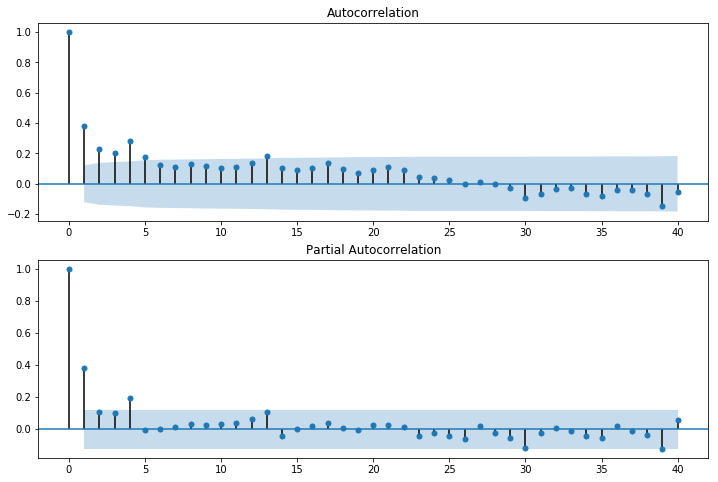

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results_ARIMA.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results_ARIMA.resid, lags=40, ax=ax2)

<br/>The above plots looks better than the previous ACF and PACF plots, let's continue and predict the values for year 2017 (just for sanity)

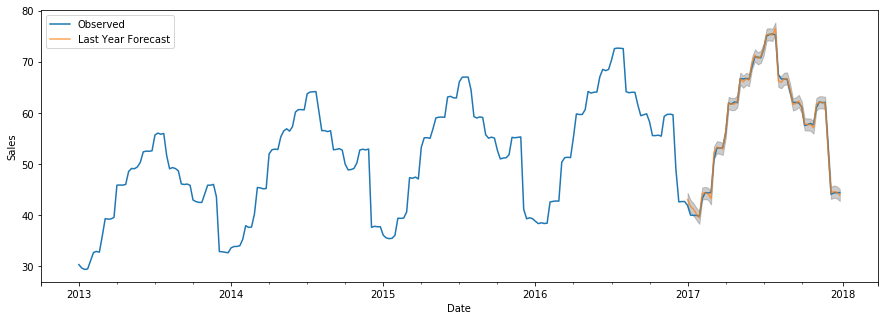

In [12]:
pred = results_ARIMA.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)#predict(start='2013-01-01', end='2017-12-31', dynamic=False)
pred_ci = pred.conf_int()
ax = ts['2013':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='Last Year Forecast', alpha=.7, figsize=(15, 5))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
None

In [13]:
y_forecasted = pred.predicted_mean
y_truth = ts['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts in 2017 is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts in 2017 is 0.33


## Let's forecast 3 years ahead

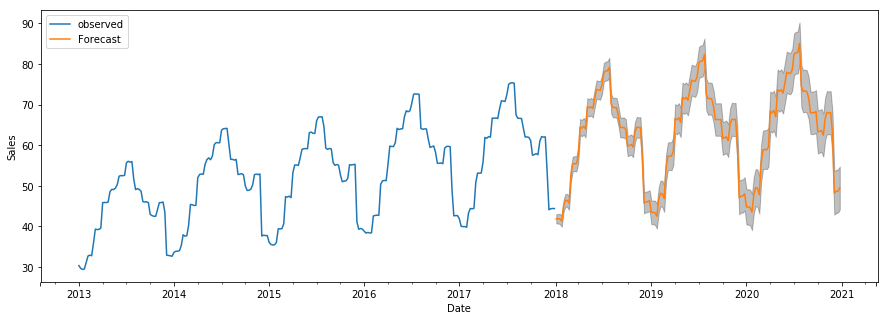

In [14]:
pred_uc = results_ARIMA.get_forecast(steps=156)
pred_ci = pred_uc.conf_int()
ax = ts.plot(label='observed', figsize=(15, 5))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
None